<p><font size="6"><b> Raster - vector tools</b></font></p>


> *DS Python for GIS and Geoscience*  
> *October, 2020*
>
> *© 2020, Joris Van den Bossche and Stijn Van Hoey. Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

In the previous notebooks, we mostly worked with either vector data or raster data. 
But, often you will encounter both types of data and will have to combine them.
In this notebook, we show *some* examples of raster/vector interactions.

In [1]:
import geopandas
import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt

In [2]:
countries = geopandas.read_file("zip://./data/ne_110m_admin_0_countries.zip")
cities = geopandas.read_file("zip://./data/ne_110m_populated_places.zip")

## Extracting values from rasters based on vector data

The **rasterstats** package provides methods to calculate summary statistics of geospatial raster datasets based on vector geometries (https://github.com/perrygeo/python-rasterstats)

To illustrate this, we are reading a raster file with elevation data of the full world (the file contains a single band for the elevation):

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["Clarke_1866",DATUM["Clarke_1866",SPHEROID["Clarke 1866",6378206.4,294.978698213898]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.0833333358168602, 0.0, -179.99999491497874,
       0.0, -0.0833333358168602, 90.00000254437327)}


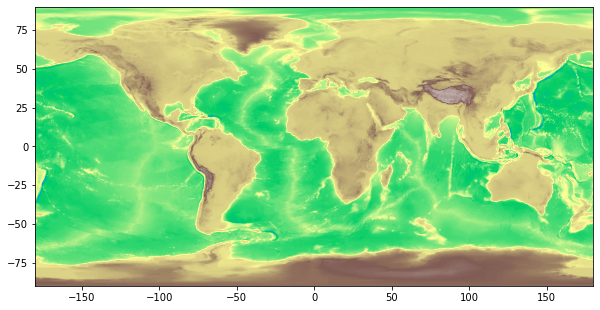

In [3]:
with rasterio.open("data/raw/DEM_geotiff/alwdgg.tif") as src:
    print(src.meta)
    fig, ax = plt.subplots(figsize=(10, 6))
    show(src, ax=ax, cmap='terrain')

Given this raster of the elevation, we might want to know the elevation at a certain location or for each country.
For the countries example, we want to extract the pixel values that fall within a country polygon, and calculate a statistic for it, such as the mean or the maximum.

Such functionality to extract information from a raster for given vector data is provided by the rasterstats package.

In [4]:
import rasterstats

For extracting the pixel values for polygons, we use the `zonal_stats` function, passing it the GeoSeries, the path to the raster file, and the method to compute the statistics.

In [5]:
result = rasterstats.zonal_stats(countries.geometry, "data/raw/DEM_geotiff/alwdgg.tif",
                                 stats=['min', 'mean', 'max'])

/home/joris/miniconda3/envs/DS-geospatial-test/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


The results can be assigned to new columns:

In [6]:
countries[['min', 'max', 'mean']] = pd.DataFrame(result)

In [7]:
countries.head()

,iso_a3,name,continent,pop_est,gdp_md_est,geometry,min,max,mean
0,AFG,Afghanistan,Asia,34124811.0,64080.0,"POLYGON ((61.21082 35.65007, 62.23065 35.27066...",244.0,5699.0,1865.941620
1,AGO,Angola,Africa,29310273.0,189000.0,"MULTIPOLYGON (((23.90415 -11.72228, 24.07991 -...",-1002.0,2103.0,1070.461868
2,ALB,Albania,Europe,3047987.0,33900.0,"POLYGON ((21.02004 40.84273, 20.99999 40.58000...",-250.0,2138.0,731.139738
3,ARE,United Arab Emirates,Asia,6072475.0,667200.0,"POLYGON ((51.57952 24.24550, 51.75744 24.29407...",-44.0,1524.0,115.114370
4,ARG,Argentina,South America,44293293.0,879400.0,"MULTIPOLYGON (((-66.95992 -54.89681, -67.56244...",-945.0,5181.0,655.130176


And then we can sort by the average elevation of the country:

In [8]:
countries.sort_values('mean', ascending=False).head()

,iso_a3,name,continent,pop_est,gdp_md_est,geometry,min,max,mean
157,TJK,Tajikistan,Asia,8468555.0,25810.0,"POLYGON ((74.980 37.420, 73.949 37.422, 73.260...",335.0,6096.0,3103.231105
85,KGZ,Kyrgyzstan,Asia,5789122.0,21010.0,"POLYGON ((80.260 42.350, 80.119 42.124, 78.544...",610.0,5791.0,2867.717142
24,BTN,Bhutan,Asia,758288.0,6432.0,"POLYGON ((91.697 27.772, 92.104 27.453, 92.033...",305.0,5486.0,2573.559846
119,NPL,Nepal,Asia,29384297.0,71520.0,"POLYGON ((81.111 30.183, 81.526 30.423, 82.328...",61.0,6705.0,2408.907816
6,ATA,Antarctica,Antarctica,4050.0,810.0,"MULTIPOLYGON (((-59.572 -80.040, -59.866 -80.5...",-1970.0,4115.0,2374.075028


For points, a similar function called `point_query` can be used (specifying the interpolation method):

In [9]:
cities["elevation"] = rasterstats.point_query(cities.geometry, "data/raw/DEM_geotiff/alwdgg.tif", interpolate='bilinear')

/home/joris/miniconda3/envs/DS-geospatial-test/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [10]:
cities.sort_values(by="elevation", ascending=False).head()

,name,geometry,elevation
122,La Paz,POINT (-68.15193 -16.49603),4378.784708
126,Thimphu,POINT (89.63901 27.47299),3554.551761
114,Sucre,POINT (-65.25952 -19.04097),3116.501683
88,Quito,POINT (-78.50200 -0.21304),2748.044039
211,Kabul,POINT (69.18131 34.51864),2588.508886


## Convert vector to raster



As example, we are using data from the Zwalm river area in Flanders. 

The digital elevation model (DEM) can be downloaded via the [governmental website](https://download.vlaanderen.be/Producten/Detail?id=936&title=Digitaal_Hoogtemodel_Vlaanderen_II_DSM_raster_5_m) ([download link](https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-5m/DHMVIIDSMRAS5m_k30.zip), extracted in the `/data` directory for this example)/ 

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 6400, 'height': 4000, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(5.0, 0.0, 98000.0,
       0.0, -5.0, 178000.0)}


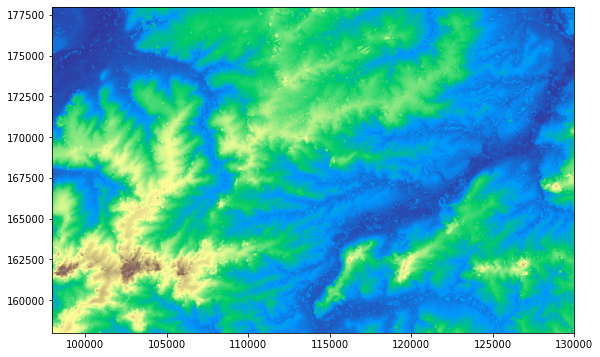

In [11]:
with rasterio.open("data/DHMVIIDSMRAS5m_k30/GeoTIFF/DHMVIIDSMRAS5m_k30.tif") as src:
    print(src.meta)
    transform =src.transform
    fig, ax = plt.subplots(figsize=(10, 6))
    show(src, ax=ax, cmap='terrain')

Next, we download the shapes of the rivers in the area through a WFS (Web Feature Service):

In [12]:
import json
import requests

wfs_rivers = "https://geoservices.informatievlaanderen.be/overdrachtdiensten/VHAWaterlopen/wfs"
params = dict(service='WFS', version='1.1.0', request='GetFeature',
              typeName='VHAWaterlopen:Wlas', outputFormat='json',
              cql_filter="(VHAZONENR=460)OR(VHAZONENR=461)", srs="31370")

# Fetch data from WFS using requests
r = requests.get(wfs_rivers, params=params)

And convert this to a GeoDataFrame:

In [13]:
# Create GeoDataFrame from geojson
segments = geopandas.GeoDataFrame.from_features(json.loads(r.content), crs="epsg:31370")

In [14]:
segments.head()

,geometry,UIDN,OIDN,VHAS,VHAG,NAAM,REGCODE,REGCODE1,BEHEER,CATC,...,BEKNR,BEKNAAM,STRMGEB,KWALDOEL,LBLKWAL,GEO,LBLGEO,VHAZONENR,WTRLICHC,bbox
0,"LINESTRING (104155.250 174948.957, 104147.271 ...",356290,65768,6020608,5001,Zwalmbeek,OS266a,,V0104,1,...,6,Boven-Scheldebekken,Schelde,110,Produktie drinkwater,2,< 0.25 m,461,VL11_63,"[103860.8019, 174948.9569, 104155.2501, 175052..."
1,"LINESTRING (101574.265 175606.789, 101569.762 ...",358955,65539,6020496,5000,Zwalmbeek,OS266,,V0104,1,...,6,Boven-Scheldebekken,Schelde,131,Viswater en prod. drinkwater,2,< 0.25 m,461,VL11_63,"[100861.5388, 175566.6373, 101574.2653, 175682..."
2,"LINESTRING (100870.618 175566.637, 100868.874 ...",358962,65737,6020577,5000,Zwalmbeek,OS266,,V0104,1,...,6,Boven-Scheldebekken,Schelde,131,Viswater en prod. drinkwater,2,< 0.25 m,461,VL11_63,"[100688.0183, 175562.7066, 100870.6185, 175615..."
3,"LINESTRING (106457.412 174082.427, 106455.008 ...",358966,65777,6020617,5000,Zwalmbeek,OS266,,V0104,1,...,6,Boven-Scheldebekken,Schelde,131,Viswater en prod. drinkwater,2,< 0.25 m,461,VL11_63,"[105901.209, 174057.7072, 106457.412, 174494.3..."
4,"LINESTRING (105267.452 174665.979, 105262.210 ...",376442,65542,6020499,5000,Zwalmbeek,OS266,,V0104,1,...,6,Boven-Scheldebekken,Schelde,131,Viswater en prod. drinkwater,2,< 0.25 m,461,VL11_63,"[104750.3062, 174665.9791, 105267.4518, 174791..."


<AxesSubplot:>

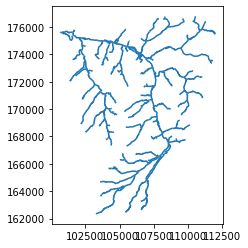

In [16]:
segments.plot()

To create a raster with the vector "burned in", we can use the `raster.features.rasterize` function. This expects a list of (shape, value) tuples, and an output image shape and transform. Here, we will create a new raster image with the same shape and extent as the DEM above. And we first take a buffer of the river lines:

In [17]:
segments_buffered = segments.geometry.buffer(100)

In [18]:
img = rasterio.features.rasterize(zip(segments_buffered, [1]*len(segments_buffered)), out_shape=(4000, 6400), transform=transform)

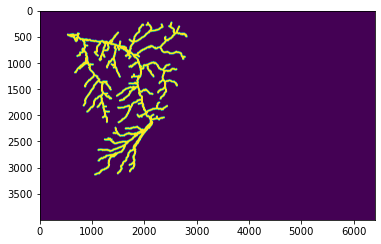

In [19]:
plt.imshow(img)